In [28]:
import numpy as np
import torch
import torch.nn as nn
import torch.distributions as D
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [30]:
import numpy as np
import torch
import matplotlib
import tqdm
import sklearn

# Print versions
print("numpy version:", np.__version__)
print("torch version:", torch.__version__)
print("matplotlib version:", matplotlib.__version__)
print("tqdm version:", tqdm.__version__)
print("scikit-learn version:", sklearn.__version__)


numpy version: 2.0.2
torch version: 2.6.0
matplotlib version: 3.9.4
tqdm version: 4.67.1
scikit-learn version: 1.6.1


### Data Loading and Preprocessing

This loads experimental and Monte Carlo data, extracts the first 8 columns. 

In [19]:
data_path = "/Users/spin/RUS_Extended_Exp/Preprocess/exp_data_filtered.npy"   
independent_data_path = "/Users/spin/RUS_Extended_MC/Preprocess/mc_comb_data.npy"   

exp_data = np.load(data_path)
exp_8d = exp_data[:, 0:8]
mc_data = np.load(independent_data_path)
mc_8d = mc_data[:, 0:8]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data Scaling and Tensor Conversion

This combines the experimental and Monte Carlo data, scales them using `StandardScaler`, and converts them into PyTorch tensors. It also creates condition flags (`0` for MC data and `1` for experimental data) and combines the data and condition flags for further processing.


In [20]:
#Scale Data Together----
combined = np.concatenate([mc_8d, exp_8d], axis=0)
scaler = StandardScaler()
scaler.fit(combined)
mc_scaled = scaler.transform(mc_8d)
exp_scaled = scaler.transform(exp_8d)
mc_tensor = torch.tensor(mc_scaled, dtype=torch.float32, device=device)
exp_tensor = torch.tensor(exp_scaled, dtype=torch.float32, device=device)

print("Loaded experimental data shape:", exp_tensor.shape)  # (N, 8)
print("Loaded MC (source) data shape:", mc_tensor.shape)     # (N, 8)

# Create condition flags: 0 for source (MC), 1 for target (experimental)
cond_mc = torch.zeros((mc_tensor.shape[0], 1), device=device)
cond_exp = torch.ones((exp_tensor.shape[0], 1), device=device)
X_combined = torch.cat([mc_tensor, exp_tensor], dim=0)
cond_combined = torch.cat([cond_mc, cond_exp], dim=0)


Loaded experimental data shape: torch.Size([239870, 8])
Loaded MC (source) data shape: torch.Size([1467839, 8])


### Define Custom Conditional Affine Coupling Transform and Build Normalizing Flow

This defines a custom conditional affine coupling transform (`ConditionalAffineCoupling`) using a neural network to compute scaling and translation parameters. It also defines a simple permutation transform (`Permute`) for reordering features. 

The `create_conditional_flow` function constructs a conditional normalizing flow by stacking multiple conditional affine coupling transforms and permutation layers to form the desired flow model.


In [21]:
class ConditionalAffineCoupling(nn.Module):
    """
    A conditional affine coupling transform.
    Splits input x into two halves, concatenates the condition to the first half,
    and uses an DNN to compute scaling (s) and translation (t) parameters.
    """
    def __init__(self, dim, hidden_dim, condition_dim=1):
        super().__init__()
        self.dim = dim
        self.condition_dim = condition_dim
        # The network takes (dim//2 + condition_dim) inputs and outputs 2*(dim//2) parameters.
        self.net = nn.Sequential(
            nn.Linear(dim // 2 + condition_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * (dim // 2))
        )
    
    def forward(self, x, cond):
        # Split x into two parts along the last dimension.
        x1, x2 = x.chunk(2, dim=-1)
        # Concatenate x1 with the condition.
        x1_cond = torch.cat([x1, cond], dim=-1)
        theta = self.net(x1_cond)
        s, t = theta.chunk(2, dim=-1)
        s = torch.clamp(s, min=-5, max=5)
        y2 = x2 * torch.exp(s) + t
        y = torch.cat([x1, y2], dim=-1)
        log_det = s.sum(dim=-1)
        return y, log_det

    def inverse(self, y, cond):
        # Inverse transformation.
        y1, y2 = y.chunk(2, dim=-1)
        y1_cond = torch.cat([y1, cond], dim=-1)
        theta = self.net(y1_cond)
        s, t = theta.chunk(2, dim=-1)
        x2 = (y2 - t) * torch.exp(-s)
        x = torch.cat([y1, x2], dim=-1)
        log_det = -s.sum(dim=-1)
        return x, log_det

class Permute(nn.Module):
    """
    A simple permutation transform that reorders features.
    """
    def __init__(self, permutation):
        super().__init__()
        # Store permutation and its inverse as buffers.
        self.register_buffer("permutation", permutation)
        self.register_buffer("inverse_permutation", torch.argsort(permutation))

    def forward(self, x):
        return x[:, self.permutation]

    def inv(self, x):
        return x[:, self.inverse_permutation]

def create_conditional_flow(dim, num_layers=4, hidden_dim=128, condition_dim=1):
    transforms = []
    for _ in range(num_layers):
        coupling = ConditionalAffineCoupling(dim, hidden_dim, condition_dim)
        transforms.append(coupling)
        perm = torch.randperm(dim)
        permute = Permute(perm)
        transforms.append(permute)
    return transforms

### Build and Train Conditional Normalizing Flow

1. **Model Setup:**
   - A base distribution is defined as an 8-dimensional standard normal distribution.
   - A conditional normalizing flow is built using `create_conditional_flow`, which consists of 12 layers, each containing an affine coupling transform and a permutation.

2. **Helper Functions:**
   - `conditional_forward`: Applies the forward pass of the normalizing flow, returning the transformed data and the log-determinant.
   - `conditional_inverse`: Applies the inverse pass, returning the original data and the log-determinant.
   - `conditional_log_prob`: Computes the log-probability of the data under the normalizing flow.

3. **Training Function:**
   - `train_conditional_flow`: A training loop that optimizes the normalizing flow using the Adam optimizer. It minimizes the negative log-probability of the data using backpropagation and gradient clipping.


In [22]:
dim = 8  # Eight features 
num_layers = 12 # flow layers
hidden_dim = 128
transforms = create_conditional_flow(dim, num_layers, hidden_dim, condition_dim=1)

# Define a base distribution: 8D standard normal using torch.distributions.
base_dist = D.Independent(
    D.Normal(torch.zeros(dim, device=device), torch.ones(dim, device=device)),
    1
)

def conditional_forward(x, cond, transforms):
    log_det_total = torch.zeros(x.shape[0], device=x.device)
    z = x
    for transform in transforms:
        if isinstance(transform, ConditionalAffineCoupling):
            z, log_det = transform.forward(z, cond)
        else:
            # Permutation transform; log-det is 0.
            z = transform(x=z)
            log_det = 0
        log_det_total += log_det
    return z, log_det_total

def conditional_inverse(z, cond, transforms):
    log_det_total = torch.zeros(z.shape[0], device=z.device)
    x = z
    # Apply inverse transforms in reverse order.
    for transform in reversed(transforms):
        if isinstance(transform, ConditionalAffineCoupling):
            x, log_det = transform.inverse(x, cond)
        else:
            x = transform.inv(x)
            log_det = 0
        log_det_total += log_det
    return x, log_det_total

def conditional_log_prob(x, cond, base_dist, transforms):
    z, log_det = conditional_forward(x, cond, transforms)
    return base_dist.log_prob(z) + log_det


def train_conditional_flow(transforms, base_dist, data_tensor, cond_tensor,
                           epochs=8950, batch_size=512, lr=1e-3, grad_clip=1.0):
    params = []
    for transform in transforms:
        if isinstance(transform, ConditionalAffineCoupling):
            params += list(transform.parameters())
    optimizer = torch.optim.Adam(params, lr=lr)
    losses = []
    num_samples = data_tensor.shape[0]
    for epoch in tqdm(range(epochs), desc="Training"):
        indices = torch.randint(0, num_samples, (batch_size,))
        x_batch = data_tensor[indices]
        cond_batch = cond_tensor[indices]
        loss = -conditional_log_prob(x_batch, cond_batch, base_dist, transforms).mean()
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(params, grad_clip)
        optimizer.step()
        losses.append(loss.item())
    return losses

### Train the Conditional Flow and Morph Simulation to Experimental Data

1. **Training the Conditional Flow:**
   - The `train_conditional_flow` function is used to train the normalizing flow model on the combined MC (source) and experimental (target) data. The training process minimizes the negative log-likelihood to morph the source (MC) data distribution to match the target (experimental) data distribution.

2. **Morphing Simulation (MC) Data to Experimental Data:**
   - The function `morph_simulation_to_data` is used to transform the MC data to match the experimental data by passing through the trained normalizing flow. The source data is first passed through the forward pass, and then an inverse pass is applied to convert it into the target (experimental) distribution.

3. **Scaling Recovery:**
   - After morphing the MC data to experimental data, the scaling applied to the data earlier is reversed using the `scaler.inverse_transform` method, recovering the original units of both MC and experimental data.



In [23]:

print("Training conditional flow on combined MC (source) and experimental (target) data...")
train_losses = train_conditional_flow(transforms, base_dist, X_combined, cond_combined)
@torch.no_grad()

def morph_simulation_to_data(x_source, transforms):
    # Use condition 0 for source (MC) and 1 for target (experimental)
    cond_source = torch.zeros((x_source.shape[0], 1), device=x_source.device)
    cond_target = torch.ones((x_source.shape[0], 1), device=x_source.device)
    z, _ = conditional_forward(x_source, cond_source, transforms)
    x_corrected, _ = conditional_inverse(z, cond_target, transforms)
    return x_corrected

corrected_samples_scaled = morph_simulation_to_data(mc_tensor, transforms)
corrected_samples_scaled = corrected_samples_scaled.cpu().numpy()

# Inverse transform the scaling to recover original units.
mc_data_orig = scaler.inverse_transform(mc_tensor.cpu().numpy())
exp_data_orig = scaler.inverse_transform(exp_tensor.cpu().numpy())
corrected_samples = scaler.inverse_transform(corrected_samples_scaled)


Training conditional flow on combined MC (source) and experimental (target) data...


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████| 8950/8950 [00:55<00:00, 159.98it/s]


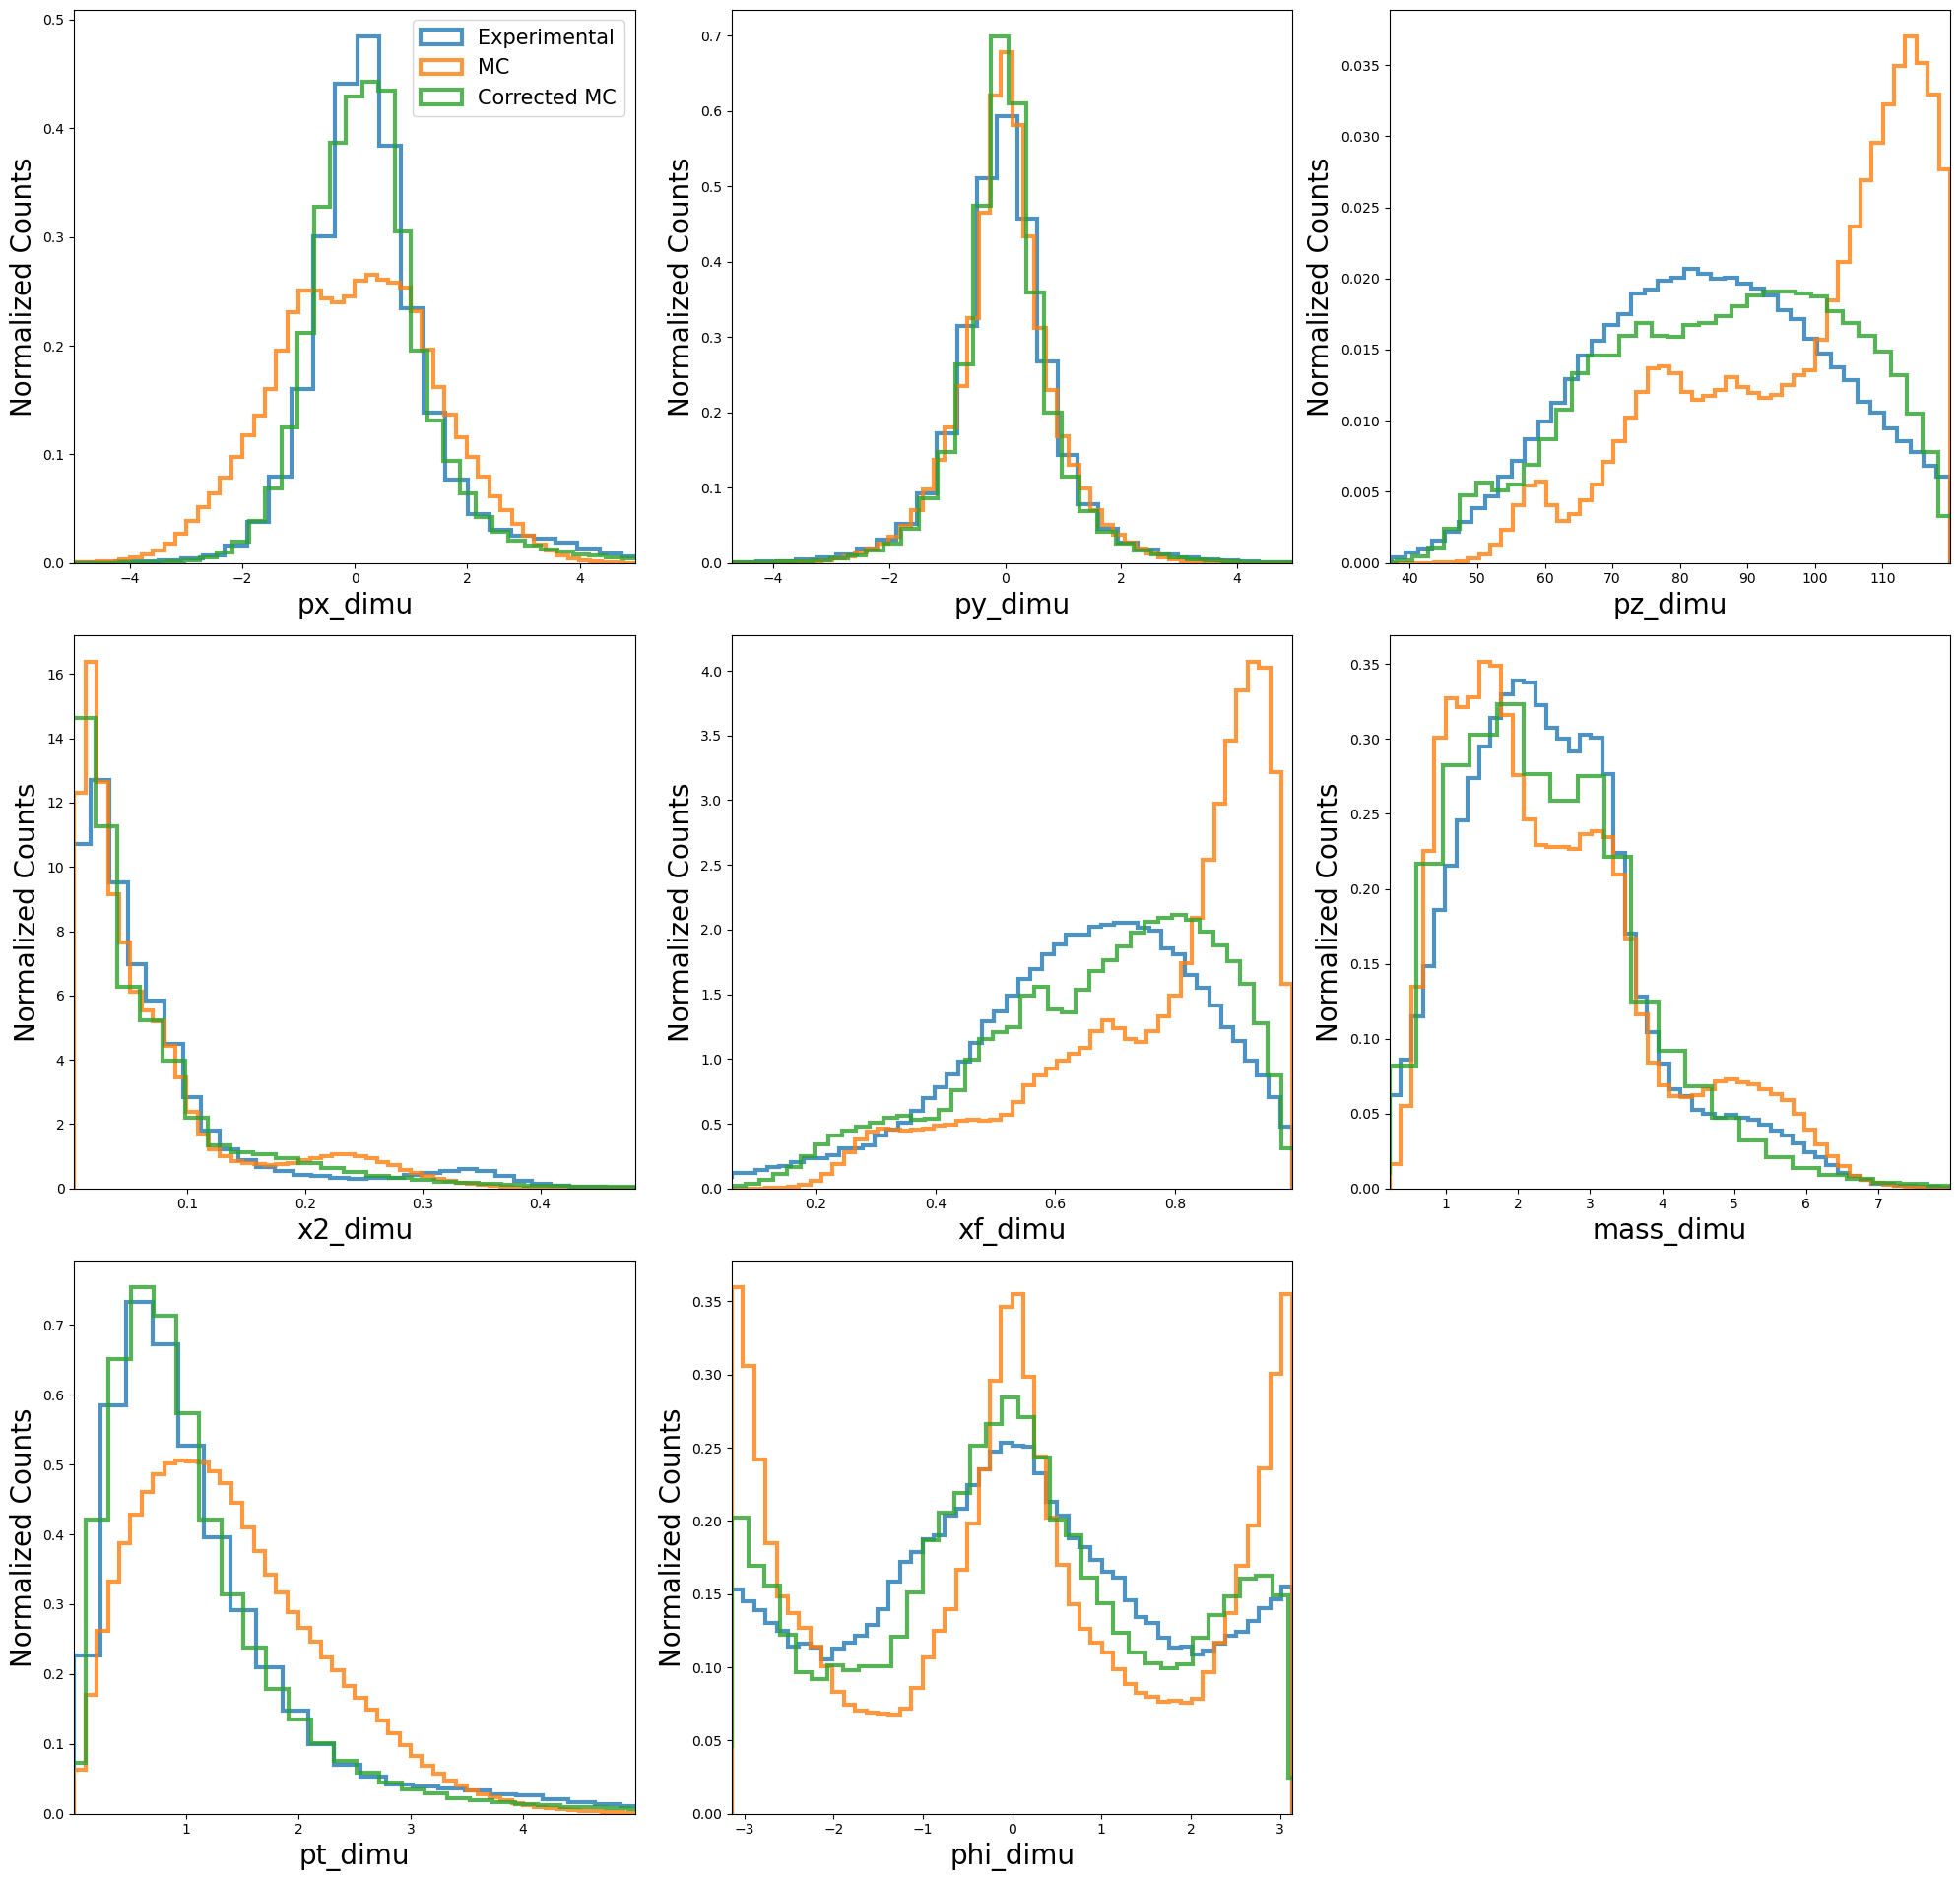

In [24]:
feature_names = [
    'px_dimu', 'py_dimu', 'pz_dimu', 'x2_dimu',
    'xf_dimu', 'mass_dimu', 'pt_dimu', 'phi_dimu'
]

num_features = exp_data_orig.shape[1]  
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten()

for i in range(num_features):
    ax = axes[i]
    feature_min = mc_data_orig[:, i].min()
    feature_max = mc_data_orig[:, i].max()
    ax.hist(exp_data_orig[:, i], bins=50, alpha=0.8, label='Experimental',
            density=True, histtype='step', linewidth=3)
    ax.hist(mc_data_orig[:, i], bins=50, alpha=0.8, label='MC',
            density=True, histtype='step', linewidth=3)
    ax.hist(corrected_samples[:, i], bins=50, alpha=0.8, label='Corrected MC',
            density=True, histtype='step', linewidth=3)

    ax.set_xlabel(f'{feature_names[i]}',fontsize=20)
    ax.set_ylabel("Normalized Counts",fontsize=20)
    # ax.set_title(f'Feature {i+1}\nMC Min: {feature_min:.2f}, MC Max: {feature_max:.2f}')
    # ax.set_title(f'{feature_names[i]}',fontsize=15)

    ax.set_xlim(feature_min, feature_max)
    
    if i == 0:
        ax.legend(fontsize=15)
    else:
        ax.legend().set_visible(False)

axes[8].axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("morphed.pdf", dpi=300, bbox_inches='tight')
plt.show()